Example of runnning CBM iteratively. CBM is run for several intervals with an opportunity to adjust disturbance events between each interval.  

The script creates a seperate CBM-CFS3 project for each simulation interval and injects the previous simulation state into each subsequent interation.

Each interval's CBM-CFS3 project has varying disturbance levels, in this case the script sets the harvest C target to be 5% of each previous iteration's end-of-interval total biomass C.

In [36]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [37]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()

import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data.aidb import AIDB
from cbm3_python.cbm3data.accessdb import AccessDB
from cbm3_python.cbm3data.projectdb import ProjectDB
from cbm3_python.simulation.simulator import Simulator
from cbm3_python.cbm3data import cbm3_results

In [38]:
local_working_dir = os.path.abspath(".")
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb")
cbm_exe_path=os.path.join(toolbox_path, "admin", "executables")
cbm_wd = os.path.join(toolbox_path, "temp")

#the number of steps in each iteration
iteration_steps = 10
#the number of iterations
num_iterations = 5

The following methods inject disturbances and transition rules into the iteration import function.

In [39]:
def create_event_factory(events):
    def factory(config):
        for e in events:
            config.add_event(**e)
    return factory
            
def create_transition_rule_factory(transitions):
    def factory(config):
        for t in transitions:
            config.add_transition_rule(**t)
    return factory

Updates the number of timesteps to run for the given CBM project (AccessDB instance)

In [40]:
def set_project_run_length(proj, n_steps):
    proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", n_steps)

Path helper functions

In [41]:
def get_project_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_{}.mdb".format(iteration_num))

def get_results_db_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_results_{}.mdb".format(iteration_num))

def get_config_save_path(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_config_{}.json".format(iteration_num))

def get_iteration_tempfiles_dir(iteration_num):
    return os.path.join(local_working_dir, "iterative_cbm", "iterative_cbm_tempfiles_{}".format(iteration_num))

Sets up and imports a constant SIT inventory with varying events and transition rules at the specified path

In [42]:
def iteration_import(project_path, config_save_path, events_factory, transition_factory):


    c = sit_helper.SITConfig(
        imported_project_path=project_path,
        initialize_mapping=True
    )
    c.data_config(
        age_class_size=5,
        num_age_classes=14,
        classifiers=["admin", "eco", "Leading Species", "Land Cover"])

    c.set_admin_eco_mapping("admin","eco")
    c.set_species_classifier("Leading Species")
    c.map_species("Nonforest", "Not stocked")

    c.add_inventory(classifier_set=["British Columbia", "Boreal Cordillera", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Boreal Plains", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Taiga Plains", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Pacific Maritime", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    c.add_inventory(classifier_set=["British Columbia", "Montane Cordillera", "Luvisolic (W. Canada)", "Nonforest"],
                    area=100, age=0, unfccc_land_class=1)
    
    c.add_inventory(classifier_set=["British Columbia", "Boreal Cordillera", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Boreal Plains", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Taiga Plains", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Pacific Maritime", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    c.add_inventory(classifier_set=["British Columbia", "Montane Cordillera", "Spruce", "Forest Only"],
                    area=1000, age=50, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")

    growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]

    not_stocked_growth = [0.0]*len(growth_curve_data)

    c.add_yield(classifier_set=["?","?","?","Nonforest"],
                leading_species_classifier_value="Not stocked",
                values=not_stocked_growth)

    c.add_yield(classifier_set=["?","?","Red pine","Forest Only"], 
                leading_species_classifier_value="Red pine", values=growth_curve_data)
    
    c.add_yield(classifier_set=["?","?","Spruce","Forest Only"], 
                leading_species_classifier_value="Spruce", values=growth_curve_data)
    
    events_factory(c)
    transition_factory(c)
    
    c.import_project(standard_import_tool_plugin_path, config_save_path)

    

Set up the first iteration.  This is a typical CBM run the since the stand initialization routine (Makelist) is run to estimate initial forest conditions.


In [43]:
events = [
    {
    "classifier_set": ["?","?","?","?"],
    "disturbance_type": "Afforestation", 
    "time_step": 1, 
    "target": 100,
    "target_type": "Area",
    "sort": "SORT_BY_SW_AGE"
    }
]
transitions = [
    {
    "classifier_set_source": ["?","?","?","?"],
    "classifier_set_target": ["?","?","Red pine","Forest Only"],
    "disturbance_type": "Afforestation",
    "percent": 100
    }
]

iteration_num = 1
project_path = get_project_path(iteration_num)
tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
results_db_path = get_results_db_path(iteration_num)

iteration_import(
    project_path,
    get_config_save_path(iteration_num),
    create_event_factory(events),
    create_transition_rule_factory(transitions))

In [44]:
with AIDB(aidb_path, False) as aidb, \
     AccessDB(project_path, False) as proj:

    set_project_run_length(proj, iteration_steps)
    simId = aidb.AddProjectToAIDB(proj)
    s = Simulator(cbm_exe_path,
                simId,
                os.path.dirname(project_path),
                cbm_wd,
                toolbox_path)
    

    s.CleanupRunDirectory()
    s.CreateMakelistFiles()
    s.copyMakelist()
    s.runMakelist()
    s.loadMakelistSVLS()
    s.DumpMakelistSVLs()
    s.CreateCBMFiles()
    s.CopyCBMExecutable()
    s.RunCBM()
    s.CopyTempFiles(output_dir=tempfiles_dir)
    s.LoadCBMResults(output_path = results_db_path)

now run subsequent iterations

In [45]:

for i in range(2,num_iterations+1):
    iteration_num = i
    project_path = get_project_path(iteration_num)
    tempfiles_dir = get_iteration_tempfiles_dir(iteration_num)
    results_db_path = get_results_db_path(iteration_num)

    #get the total biomass from a previous iteration
    total_biomass = cbm3_results.load_pool_indicators( get_results_db_path(i-1))["Total Biomass"][-1:].values[0]
    #set the target to 5% of the total biomass from the previous iteration
    targetC = total_biomass * 0.05
    
    #create a series of events (divided by the number of iterations)
    events = [
        {
        "classifier_set": ["?","?","?","?"],
        "disturbance_type": "Clear-cut with slash-burn", 
        "time_step": x+1, 
        "target": targetC/iteration_steps,
        "target_type": "Merchantable",
        "sort": "MERCHCSORT_TOTAL"
        } for x in range(iteration_steps)
    ]
    
    #import the project with new disturbance events
    iteration_import(
        project_path,
        get_config_save_path(iteration_num),
        create_event_factory(events),
        create_transition_rule_factory([]))
    
    with AIDB(aidb_path, False) as aidb, \
         AccessDB(project_path, False) as proj:

        proj.ExecuteQuery("UPDATE tblRunTableDetails SET tblRunTableDetails.RunLength = ?", iteration_steps)
        simId = aidb.AddProjectToAIDB(proj)
        s = Simulator(cbm_exe_path,
                    simId,
                    os.path.dirname(project_path),
                    cbm_wd,
                    toolbox_path)

        s.CleanupRunDirectory()
        s.CopyToWorkingDir(project_path)
        s.CreateCBMFiles()
        s.CopyCBMExecutable()
        s.CopySVLFromPreviousRun(os.path.join(get_iteration_tempfiles_dir(i-1),"CBMRun","output"))
        s.RunCBM()
        s.CopyTempFiles(output_dir=tempfiles_dir)
        s.LoadCBMResults(output_path = results_db_path)
   

In [47]:
cbm3_results.load_pool_indicators( get_results_db_path(1))["Total Biomass"]
    

0     743087.000000
1     750480.858243
2     757862.770354
3     765233.164056
4     772562.099311
5     779895.401373
6     785996.818458
7     792089.588088
8     798173.813222
9     804249.499984
10    810316.732337
Name: Total Biomass, dtype: float64

In [48]:
cbm3_results.load_pool_indicators( get_results_db_path(2))["Total Biomass"]
    

0     810316.732337
1     802237.004302
2     794169.502587
3     786124.616734
4     778113.603189
5     770148.304355
6     762240.945831
7     754403.977446
8     746649.929591
9     738991.303995
10    731440.457664
Name: Total Biomass, dtype: float64

In [49]:
cbm3_results.load_pool_indicators( get_results_db_path(3))["Total Biomass"]

0     731440.495758
1     724796.002726
2     718281.942047
3     711908.608427
4     705685.690527
5     699622.191923
6     693726.421726
7     688005.908232
8     682467.382662
9     677116.726110
10    671583.667819
Name: Total Biomass, dtype: float64

In [50]:
cbm3_results.load_pool_indicators( get_results_db_path(4))["Total Biomass"]

0     671583.598747
1     665885.389268
2     660412.548809
3     655176.245154
4     650184.805465
5     645444.165818
6     640958.107340
7     636728.417403
8     632755.072670
9     629036.339889
10    625568.937545
Name: Total Biomass, dtype: float64

In [51]:
cbm3_results.load_pool_indicators( get_results_db_path(5))["Total Biomass"]

0     625568.967327
1     622898.860878
2     620486.212930
3     618288.723804
4     616302.846239
5     614524.701217
6     612922.280183
7     611474.386507
8     610136.094530
9     608912.829509
10    607820.638698
Name: Total Biomass, dtype: float64

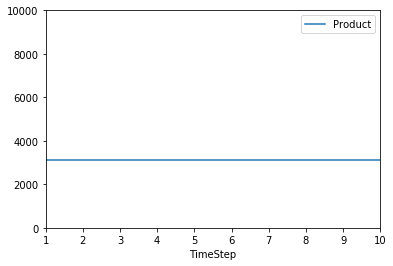

In [53]:
dist_indicators = cbm3_results.load_disturbance_indicators(
    get_results_db_path(5), 
    disturbance_type_grouping=True)

p = dist_indicators.loc[dist_indicators["DistTypeID"]==2][["TimeStep","Product"]].groupby("TimeStep").sum()
p.plot(ylim=(0,10000))